# static



In [32]:
TRAIN_PATH = '/content/drive/MyDrive/student_cup_2021/dataset/train.csv'
TEST_PATH = '/content/drive/MyDrive/student_cup_2021/dataset/test.csv'

# Loading data

In [33]:
import pandas as pd

df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

df = pd.concat([df_train.drop(['index', 'genre'], axis=1), df_test.drop(['index'], axis=1)], axis=0)

print('df_train shape: {0}, df_test shape: {1}'.format(df_train.shape, df_test.shape))
print('df shape: {0}'.format(df.shape))

df_train shape: (4046, 14), df_test shape: (4046, 13)
df shape: (8092, 12)


# ctgan

In [34]:
!pip install ctgan
!pip install table_evaluator

In [35]:
from ctgan import CTGANSynthesizer

df_train = df_train.drop(['index'], axis=1)
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)

categorical_features = ['tempo', 'region']

ctgan = CTGANSynthesizer(verbose=False)

ctgan.fit(df_train, categorical_features, epochs = 300)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error

In [36]:
df_sample = ctgan.sample(100000)

print(df_sample.head())

   genre  popularity  duration_ms  ...  instrumentalness    tempo    region
0      7          55       214409  ...          0.169655   97-120  region_B
1      7          30       215528  ...          0.218653  193-208  region_O
2      7          54       254213  ...          0.210550  193-208  region_T
3      1          19       181541  ...          0.236814  121-152  region_E
4      1          52       267568  ...          0.196526  177-192  region_S

[5 rows x 13 columns]


In [37]:
df_sample['genre'].value_counts()

8     34209
7     29632
10    12379
9      9391
2      2875
3      2851
1      2417
6      2403
5      1638
4      1255
0       950
Name: genre, dtype: int64

In [38]:
df_train['genre'].value_counts()

10    1329
8     1304
3      362
7      334
1      205
2      191
5      126
9       59
6       50
4       44
0       32
Name: genre, dtype: int64

In [39]:
df_train = pd.concat([df_train, df_sample[df_sample['genre']==0].iloc[:1300, :]], axis=0)
df_train = pd.concat([df_train, df_sample[df_sample['genre']==4].iloc[:1300, :]], axis=0)
df_train = pd.concat([df_train, df_sample[df_sample['genre']==6].iloc[:1300, :]], axis=0)
df_train = pd.concat([df_train, df_sample[df_sample['genre']==9].iloc[:1300, :]], axis=0)
df_train = pd.concat([df_train, df_sample[df_sample['genre']==5].iloc[:1200, :]], axis=0)
df_train = pd.concat([df_train, df_sample[df_sample['genre']==2].iloc[:1100, :]], axis=0)
df_train = pd.concat([df_train, df_sample[df_sample['genre']==1].iloc[:1100, :]], axis=0)
df_train = pd.concat([df_train, df_sample[df_sample['genre']==7].iloc[:1000, :]], axis=0)
df_train = pd.concat([df_train, df_sample[df_sample['genre']==3].iloc[:1000, :]], axis=0)

df = pd.concat([df_train.drop(['genre'], axis=1), df_test.drop(['index'], axis=1)], axis=0)

print(df_train.shape)
print(df_test.shape)
print(df.shape)

(14241, 13)
(4046, 13)
(18287, 12)


# Preprocessing

In [40]:
df['tempo_max'] = df['tempo'].str.split('-').str.get(1).astype(int)
df = pd.concat([df, pd.get_dummies(df['tempo'])], axis=1)
df = df.drop(['tempo'], axis=1)
df = pd.concat([df, pd.get_dummies(df['region'])], axis=1)
df = df.drop(['region'], axis=1)

col_list = ['popularity', 'duration_ms', 'acousticness', 'positiveness', 'danceability',
            'loudness', 'energy', 'liveness', 'speechiness', 'instrumentalness',
            'tempo_max',]

for col in col_list:
  df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

In [41]:
print(df.shape)

(18287, 44)


In [42]:
df.describe()

,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo_max,0-40,121-152,153-176,177-192,193-208,209-220,41-50,51-56,57-63,64-76,77-96,97-120,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,region_K,region_L,region_M,region_N,region_O,region_P,region_Q,region_R,region_S,region_T,unknown
count,18287.000000,18287.000000,18286.000000,18273.000000,18276.000000,18287.000000,18286.000000,18281.000000,18276.000000,18285.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000,18287.000000
mean,0.499180,0.114037,0.376943,0.511522,0.458078,0.766261,0.656627,0.241616,0.193950,0.210626,0.567959,0.000766,0.292722,0.107727,0.120304,0.043638,0.012632,0.022858,0.004047,0.006289,0.026631,0.145076,0.217313,0.001312,0.125499,0.043309,0.105375,0.170722,0.035216,0.034998,0.037732,0.125280,0.003883,0.052988,0.025264,0.000273,0.008257,0.040903,0.047083,0.007820,0.008421,0.018866,0.044130,0.062667
std,0.175135,0.034297,0.242821,0.222867,0.165830,0.107271,0.177747,0.149260,0.077710,0.132960,0.216617,0.027659,0.455024,0.310044,0.325326,0.204293,0.111683,0.149454,0.063486,0.079053,0.161007,0.352187,0.412429,0.036204,0.331293,0.203558,0.307045,0.376276,0.184331,0.183779,0.190552,0.331045,0.062191,0.224017,0.156930,0.016534,0.090496,0.198072,0.211821,0.088085,0.091383,0.136055,0.205389,0.242371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.387097,0.094960,0.158685,0.320668,0.334842,0.712863,0.539862,0.148684,0.147423,0.148943,0.444444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.505376,0.112471,0.309829,0.514154,0.461676,0.784332,0.696854,0.197981,0.179947,0.178135,0.622222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.623656,0.130792,0.591641,0.704082,0.579872,0.840847,0.797113,0.285051,0.218564,0.212766,0.755556,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# function

In [43]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, LeakyReLU
from keras.optimizers import Adam

def create_model():

  model = Sequential()

  model.add(Dense(100, input_shape=(X_train.shape[1],)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Dense(50))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Dense(50))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  
  model.add(Dense(cY_train.shape[1], activation='softmax'))
 
  model.compile(optimizer=Adam(lr=1e-5),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'],)
  
  return model

In [44]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def cross_val_score_for_keras(X_train, cY_train, epochs, batch_size, n_splits=10):

  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2021)

  acc = []
  f1_macro = []

  for train_idx, val_idx in skf.split(X_train, cY_train.argmax(axis=1)):
    # creating dataset #
    train_data = X_train[train_idx]
    train_labels = cY_train[train_idx] 
    val_data = X_train[val_idx],
    val_labels = cY_train[val_idx]
    # creating model, save & load the best model #
    model = create_model()
    callbacks_list = [CustomCallback(model, val_data, val_labels, MODEL_PATH),]
    history = model.fit(train_data, train_labels, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=0,
                        callbacks=callbacks_list,
                        validation_data=(val_data, val_labels))
    model = load_model(MODEL_PATH)
    # calculate the metrics #
    acc_score = accuracy_score(np.argmax(val_labels, axis=1), np.argmax(model.predict(val_data), axis=1))
    acc.append(acc_score)
    score = f1_score(np.argmax(val_labels, axis=1), np.argmax(model.predict(val_data), axis=1), average='macro')
    f1_macro.append(score)

    print('accuracy: {0:.3f}, f1 macro: {1:.3f}'.format(acc_score, score))
    break

  return acc, f1_macro

# data

In [45]:
from keras.utils import to_categorical

X_train = df.iloc[:13333, :].values
cY_train = to_categorical(df_train['genre'])
X_test = df.iloc[13333:, :].values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(13333, 44)
(13333, 11)
(4954, 44)


In [46]:
df_train['genre'].value_counts()

3     1362
9     1359
6     1350
7     1334
10    1329
5     1326
1     1305
8     1304
4     1299
2     1291
0      982
Name: genre, dtype: int64

# hold-out

In [47]:
from keras.callbacks import EarlyStopping

model = create_model()
history = model.fit(X_train, cY_train, 
                    epochs=200, 
                    batch_size=32,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/200
334/334 [==============================] - 2s 3ms/step - loss: 2.6369 - accuracy: 0.0950 - val_loss: 2.6727 - val_accuracy: 0.0832
Epoch 2/200
334/334 [==============================] - 1s 2ms/step - loss: 2.5865 - accuracy: 0.1065 - val_loss: 2.9873 - val_accuracy: 0.0499
Epoch 3/200
334/334 [==============================] - 1s 2ms/step - loss: 2.5449 - accuracy: 0.1178 - val_loss: 3.0235 - val_accuracy: 0.0446
Epoch 4/200
334/334 [==============================] - 1s 2ms/step - loss: 2.4895 - accuracy: 0.1212 - val_loss: 3.0486 - val_accuracy: 0.0367
Epoch 5/200
334/334 [==============================] - 1s 2ms/step - loss: 2.4695 - accuracy: 0.1288 - val_loss: 3.0722 - val_accuracy: 0.0322
Epoch 6/200
334/334 [==============================] - 1s 2ms/step - loss: 2.4324 - accuracy: 0.1369 - val_loss: 3.0825 - val_accuracy: 0.0274
Epoch 7/200
334/334 [==============================] - 1s 2ms/step - loss: 2.3987 - accuracy: 0.1466 - val_loss: 3.0993 - val_accuracy: 0.0236

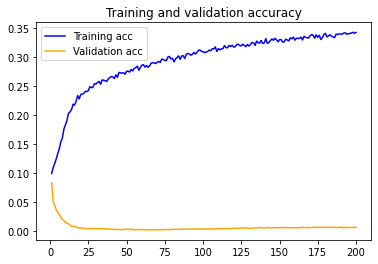

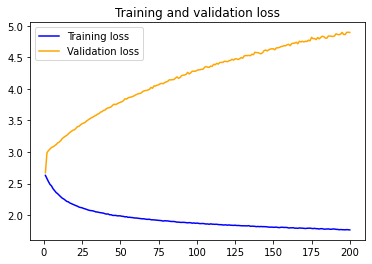

In [48]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()